In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

from collections import Counter
a4_dims = (11.69,8.27)
from scipy.stats import poisson, zipf, rv_discrete
from scipy.stats import ks_2samp
import seaborn as sns
from scipy.special import comb

In [2]:
def binom(k,k_sampled,p):
    return comb(k,k_sampled)* np.power(p,k_sampled)*np.power(1-p,k-k_sampled)

In [3]:
def edge_sample(G,p,random_seed=None):
    # optionally seed for reproducibility
    random.seed(random_seed)
    H = nx.Graph()
    for (u,v) in G.edges:
        if random.random()<p:
            H.add_edge(u,v)
    return H

In [4]:
## Basic estimator for degree sequence which does not redistribute any spare or missing links
def deg_MME_basic(k_seq,sample_prob,as_int=False):
    if sample_prob==0.0:
        return np.zeros(shape=len(k_seq), dtype=float)
    estimated = k_seq/sample_prob
    if (as_int):
        return np.array([*map(int,estimated)])
    return estimated

print(deg_MME_basic(np.array([3,2,5,2]),0.5,True))

[ 6  4 10  4]


In [6]:
## Estimator which first obtains MME one then deals with rounding discrepency by redistributing links
def deg_MME(sampled_graph, probability_keep, redistribute_links=True):

    # Number of nodes/links in sampled graph
    N_prime, M_prime = sampled_graph.number_of_nodes(), sampled_graph.number_of_edges()

    ## Estimated number of links from sampled graph
    M_estimated = int(M_prime/p)

    ## Sampled and scaled-up degree distribution
    k_prime = np.array([d for (_,d) in nx.degree(sampled_graph)])
    k_est = deg_MME_basic(k_seq=k_prime,sample_prob=probability_keep,as_int=True)

    if (redistribute_links==False):
        return np.array(k_est)

    ## "Left over" stubs from the rounding process
    k_spare = 2*M_estimated - sum(k_est)

    ## Distribute these random stubs if there are any
    if k_spare>0:
        sampled_nodes = random.sample(range(N_prime),k_spare)
        for node in sampled_nodes:
            k_est[node]+=1

    ## If we have given nodes more connections than there are links, randomly remove some
    if k_spare<0:
        non_isolated_nodes = list(filter(lambda ind: k_est[ind]>0, range(N_prime)))
        sampled_nodes = random.sample(non_isolated_nodes,abs(k_spare))
        for node in sampled_nodes:
            k_est[node]-=1
    
    return np.array(k_est) 

In [19]:
def monte_carlo_degree(sampled_graph,probability_keep):

    # Number of nodes/links in sampled graph
    N_prime, M_prime = sampled_graph.number_of_nodes(), sampled_graph.number_of_edges()

    observed_degree = np.array([d for (_,d) in nx.degree(sampled_graph)])
    estimated_degree = deg_MME(sampled_graph=sampled_graph, probability_keep=probability_keep,redistribute_links=True)

    ## Expected degree of sampled network according to binomial
    sampled_sequence = estimated_degree * probability_keep *1.0
    #print(sampled_sequence)

    ## Sum of squared distances as base quality metric
    ssd_current = sum((sampled_sequence - observed_degree)**2)
    #print(observed_degree)
    
    # Commence Monte Carlo process
    # NB stuck in global minima if 1/p is an integer.
    cts_accept=0
    for i in range(15000):
        ## Randomly rewire an edge
        [n1, n2] = random.sample(range(N_prime),2)
        # if i==1:
        #     print(n1,n2)

        ## Ensure we don't leave any isolated nodes
        while(estimated_degree[n1]<=1):
            [n1,n2] = random.sample(range(N_prime),2)
        estimated_degree[n1]-=1
        estimated_degree[n2]+=1

        sampled_sequence = estimated_degree * probability_keep
        ssd_new = sum((sampled_sequence - observed_degree)**2)

        ## Reject step if error is larger:
        if (ssd_new > ssd_current):
            estimated_degree[n1]+=1
            estimated_degree[n2]-=1
        else:
            ssd_current = ssd_new
            cts_accept+=1

    return estimated_degree, ssd_current, cts_accept



In [41]:
def bayes_approx(prior_as_sequence,sampled_graph,prob_retain):
    observed = np.array([d for (_,d) in nx.degree(sampled_graph)])
    N_approx = len(prior_as_sequence)

    ## transform from degree sequence to degree distribution
    deg_counts = Counter(prior_as_sequence)

    ## max value to use for the degree
    k_max = max(deg_counts.elements())

    ## construct prior from approx sequence
    prior = [deg_counts[k]/N_approx for k in range(k_max+1)]
    posterior = np.zeros(N_approx)

    for i in range(N_approx):
        k_observed = observed[i]
        k_range = range(k_observed,k_max+1)

        ## lambda function so can be applied to numpy array
        binom_ev = lambda k : binom(k,k_observed,prob_retain)

        denom = np.dot(binom_ev(k_range),prior[k_observed:k_max+1])
        numer = np.dot(binom_ev(k_range)*k_range,prior[k_observed:k_max+1])
        if (denom>0):
            posterior[i]=numer/denom
    return posterior
    

In [39]:
def mse(seq1, seq2):
    return sum((seq1-seq2)**2)/len(seq1)

In [48]:
N,M=1000,5000
G = nx.gnm_random_graph(N,M)

p_range = np.linspace(0.05,1.0,20)

mme = np.zeros(len(p_range))
monte_carlo = np.zeros(len(p_range))
bayes_mc = np.zeros(len(p_range))
bayes_true = np.zeros(len(p_range))

for ind, p in enumerate(p_range):
    H = edge_sample(G,p)

    ## True degree sequence of nodes in G that are in H
    true_degrees = np.array([nx.degree(G)[n] for n in H.nodes])

    ## MME and associated error
    mme_seq = deg_MME(H,p,True)
    mme[ind] = mse(mme_seq,true_degrees)
    
    ## Monte carlo improvement
    deg, ssd_error, accepted = monte_carlo_degree(H,p)
    monte_carlo[ind] = mse(deg,true_degrees)
    
    ## Bayes using monte carlo
    posterior_mc = bayes_approx(deg,H,p)
    bayes_mc[ind] = mse(posterior_mc,true_degrees)
    
    ## Bayes using true prior
    posterior_true = bayes_approx(true_degrees,H,p)
    bayes_true[ind] = mse(posterior_true,true_degrees)

    

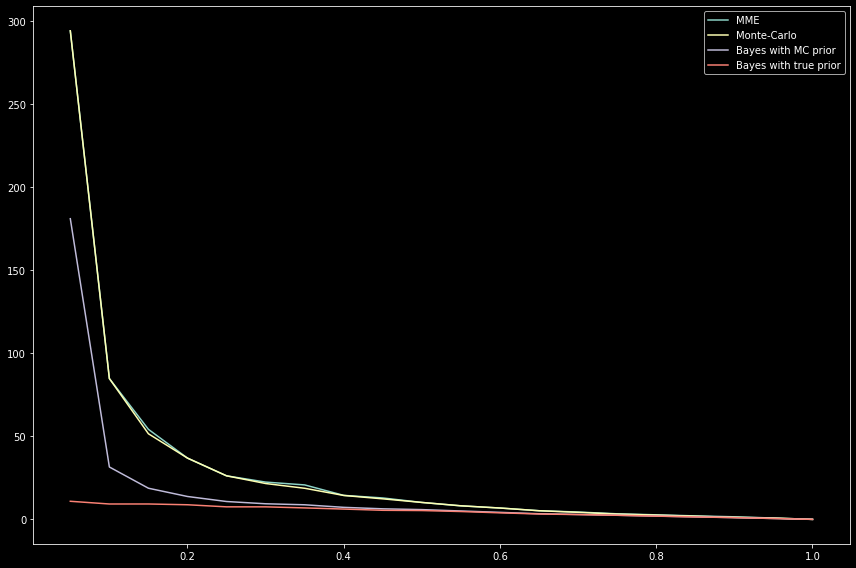

In [49]:
fig, ax = plt.subplots(figsize=(12,8))

plt.style.use("dark_background")
ax.plot(p_range,mme,label="MME")
ax.plot(p_range,monte_carlo,label="Monte-Carlo")
ax.plot(p_range,bayes_mc,label="Bayes with MC prior")
ax.plot(p_range,bayes_true,label="Bayes with true prior")

ax.legend(loc="upper right")
plt.tight_layout()
plt.style.use("dark_background")
plt.show()

In [45]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']
